# This is the first implementation

Consists of quality score box and whiskers and histogram plot, histogram plot has a slider to change the bin size.

1. we need to establish the connection to the db, otherwise there is no point in continuing after this.

2. trying to read the file, here we also define how to read the files and what are the character lengths of each of them.

3. parsing the file into a DB format. Will be trying out postgres for this implementation. Postgres was unable to be installed, will stick to mariaDB.

4. using the DB files, we are able to extract the quality scores and the matching scores. Producing the graphs of mated and non-mated frequency.

5. For the quality score, the enrolled and live quality score will be sorted together for better downstream analysis

In [10]:
%reset
import gc
import pandas as pd
import os
import psutil
import time
from tkinter import Tk
from tkinter.filedialog import askdirectory
from sqlalchemy import create_engine

# Database connection setup
def database_connection():
    DB_USER = 'root'
    try:
        with open(r'C:\Users\B&P\Documents\analytics_platform\DB_Password.txt', 'r') as file:
            DB_PASSWORD = file.read().strip()  # Strip any extra spaces/newlines
    except FileNotFoundError:
        raise Exception("DB_Password.txt file not found. Please make sure the password file is in the correct location.")
    DB_HOST = '127.0.0.1'
    DB_PORT = '3306'
    DB_NAME = 'inspectorate_implementation'
    global engine
    connection_string = f'mariadb://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
    engine = create_engine(connection_string)
database_connection()

# Function to open file dialog
def browse_button():
    global path_read
    root = Tk()
    root.withdraw()
    root.wm_attributes('-topmost', 1)
    path_read = askdirectory(title='Select Matching Score Folder')
    print(path_read)

# Function to process and store ID1, ID2, and Matching Score in SQL table
def processing():
    all_data = []  # To hold all data across files

    for root, dirs, files in os.walk(path_read):
        for file in files:
            if file.endswith('.txt'):
                file_path = os.path.join(root, file)
                print("Reading:", file)
                
                data_list = []  # Temporary list to store data from each file
                
                with open(file_path, 'r') as f:
                    lines = f.readlines()
                    
                    for line in lines:
                        values = line.strip().split(',')
                        
                        # Assuming each entry is structured to split as follows:
                        for value in values:
                            id1 = value[:7]
                            id2 = value[7:14]
                            score = value[14:18]
                            
                            data_list.append({
                                'ID1': id1,
                                'ID2': id2,
                                'Matching Score': score  # Convert score to integer for storage
                            })
                
                # Append file data to all_data for batch SQL upload
                all_data.extend(data_list)
                
                # Optional: Display memory usage
                ram_usage = round(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 3, 1)
                print(f"Ram Usage (GB): {ram_usage}")
                print(file + ' is done')
                
    # Convert all_data to DataFrame and store it in SQL
    df_all_data = pd.DataFrame(all_data)
    df_all_data.to_sql('compiled_matching_scores', con=engine, index=False, if_exists='replace')

    # Clear memory
    del all_data
    del df_all_data
    gc.collect()

browse_button()
processing()

C:/Users/B&P/Documents/analytics_platform/2.resources/matching_scores
Reading: F-2023_10_10 17_15_16.00000.txt
Ram Usage (GB): 0.5
F-2023_10_10 17_15_16.00000.txt is done
Reading: F-2023_10_10 17_15_16.00001.txt
Ram Usage (GB): 0.5
F-2023_10_10 17_15_16.00001.txt is done


In [ ]:
%reset
import gc # This is required for the ram fix
import pandas as pd # This is for the dataframe
import os # This is for the operating system functionalities like reading the file directory, etc.
import psutil
import numpy as np
import time # This is just a rough gauge for us to estimate how much time we require to process each file
from tkinter import Tk # This is to provide a user interface for the user to select the file/folder for the quality and matching scores
from tkinter.filedialog import askdirectory
from tkinter import filedialog as fd
import matplotlib.pyplot as plt # This is for the plotting of the graph
from sqlalchemy import create_engine # This is for us to interface with the SQL for the issuing of commands and retrieving information once that is done

global desired_indices
desired_indices = range(0000, 10000) # This might be required to define the index in mariaDB

# This must be done to establish connection to the database
def database_connection():
    DB_USER = 'root'
    try:
        with open(r'C:\Users\B&P\Documents\analytics_platform\DB_Password.txt', 'r') as file:
            DB_PASSWORD = file.read().strip()  # Strip any extra spaces/newlines
    except FileNotFoundError:
        raise Exception("DB_Password.txt file not found. Please make sure the password file is in the correct location.")
    DB_HOST = '127.0.0.1'
    DB_PORT = '3306'
    DB_NAME = 'iNspectorate_implementation'
    global engine
    connection_string = f'mariadb://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
    engine = create_engine(connection_string)
database_connection()

def df_collector():
    global df_true_save
    global df_false_save

    df_true_save = pd.DataFrame(columns=['score', 'count'])
    df_true_save['score'] = df_true_save['score'].astype(int) #converting the string into integer
    df_true_save.set_index('score', inplace=True)
    df_true_save = df_true_save.reindex(desired_indices)
    df_true_save['count'].fillna('0', inplace=True)
    df_true_save['count'] = df_true_save['count'].astype(int)
    df_true_save.reset_index(inplace=True)

    df_false_save = pd.DataFrame(columns=['score', 'count'])
    df_false_save['score'] = df_false_save['score'].astype(int) #converting the string into integer
    df_false_save.set_index('score', inplace=True)
    df_false_save = df_false_save.reindex(desired_indices)
    df_false_save['count'].fillna('0', inplace=True)
    df_false_save['count'] = df_false_save['count'].astype(int)
    df_false_save.reset_index(inplace=True)
    return(df_true_save,df_false_save)

def browse_button():
    global path_read
    root = Tk()
    root.withdraw()
    root.wm_attributes('-topmost', 1)
    path_read = askdirectory(title='Select Matching Score Folder') # shows dialog box and return the path
    print(path_read)


def processing():
    for root, dirs, files in os.walk(path_read):
        for file in files:
            data_list = [] 
            filename, extension = os.path.splitext(file)
            if extension == '.txt':
                print("Reading: "+file)
                file_path = os.path.join(root,file)
                with open(file_path, 'r') as f:
                    start = time.time()
                    lines = f.readlines()
                    for line in lines:
                        values = line.strip().split(',')
                        
                    for i in range(0, len(values)):
                        id1 = values[i][:7]
                        id2 = values[i][7:14]
                        score = values[i][14:18]

                        data_list.append({
                            'ID1': id1,
                            'ID2': id2,
                            'Score': score
                        })
                    f.close()
                    end = time.time()
                duration = round(end-start,1)
                df = pd.DataFrame(data_list)
                
                # Saving this compiled matching score, this one will be useful to build the entire database, for downstream analysis
                df.to_sql('compiled_matching_scores', con=engine, index=False, if_exists='replace')
                df['Same_IDs'] = df['ID1'] == df['ID2']
                df['Same_IDs'] = df['Same_IDs'].map({True: 'Y', False: 'N'})
                #making 2 dataframes
                df_true = df[df['Same_IDs'] == 'Y'].copy()
                df_false = df[df['Same_IDs'] == 'N'].copy()
                df_true.drop(df_true.tail(1).index,inplace=True)
                #print(df_true)
                #print(df_false)
                df_true.drop(columns=['Same_IDs'], inplace=True)
                df_false.drop(columns=['Same_IDs'], inplace=True)
                
                #This is dataframe that contains the mated and non-mated results
                #print("DataFrame for 'Mated' values:")
                #print(df_true)

                #print("\nDataFrame for 'Non-Mated' values:")
                #print(df_false)

                df_true.sort_values(by='Score', inplace=True)
                df_false.sort_values(by='Score', inplace=True)
                #This is the dataframe that contains the mated and non-mated results that are sorted
                #print("DataFrame for 'Mated' values:")
                #print(df_true)

                #print("\nDataFrame for 'Non-Mated' values:")
                #print(df_false)

                # Count occurrences of each score for mated
                score_counts_true = df_true['Score'].value_counts()
                
                # Convert the result to a DataFrame if needed

                result_df_true = pd.DataFrame({'score': score_counts_true.index, 'count': score_counts_true.values})
                
                result_df_true['score'] = result_df_true['score'].astype(int) #converting the string into integer
                result_df_true.set_index('score', inplace=True)
                result_df_true = result_df_true.reindex(desired_indices)
                result_df_true['count'].fillna('0', inplace=True)
                result_df_true.reset_index(inplace=True)
                result_df_true['count'] = result_df_true['count'].astype(int)
                # Save the result to a CSV file
                # result_df_true.to_csv('score_counts_true.csv', index=False)

                #Printing the results of the mated
                #print("Mated Frequency")
                #print(result_df_true)

                # This is the non-mated
                score_counts_false = df_false['Score'].value_counts()

                # Convert the result to a DataFrame if needed
                result_df_false = pd.DataFrame({'score': score_counts_false.index, 'count': score_counts_false.values})
                result_df_false['score'] = result_df_false['score'].astype(int) #converting the string into integer
                result_df_false.set_index('score', inplace=True)
                result_df_false = result_df_false.reindex(desired_indices)
                result_df_false['count'].fillna('0', inplace=True)
                result_df_false.reset_index(inplace=True)
                result_df_false['count'] = result_df_false['count'].astype(int)
                # Save the result to a CSV file
                # esult_df_false.to_csv('score_counts_false.csv', index=False)
                #Printing the results of the non-mated
                #print("Non-Mated Frequency")
                #print(result_df_false)

                #print(df)
                process = psutil.Process()
                #print(process.memory_info().rss)
                ram_usage = round(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 3,1)
                print(f"Ram Usage (GB): {ram_usage}")
                #print(f"Processing time: {duration} seconds")
                
                #df_true_save[df_true_save.columns[1]] = df_true_save[df_true_save.columns[1]] + result_df_true[result_df_true.columns[1]]
                df_true_save['count'] = df_true_save['count'] + result_df_true['count']
                df_true_save.to_csv('score_counts_true_total.csv', index=False)
                df_false_save['count'] = df_false_save['count'] + result_df_false['count']
                df_false_save.to_csv('score_counts_false_total.csv', index=False)
                
                #TABLE_NAME = 'all data'
                '''
                delete_query = f'DELETE FROM {TABLE_NAME}'
                engine.connect().execute(delete_query)
                '''
                df.drop(df.columns[[0]], axis=1, inplace=True)
                df.drop(df.columns[[0]], axis=1, inplace=True)
                df.sort_values(by='Same_IDs', inplace=True)
                df.to_sql('all_data', con=engine, index=False, if_exists='append')
                #Clearing memory to prevent RAM bottleneck
                del df_true
                del df_false
                del score_counts_true
                del score_counts_false
                del result_df_true
                del result_df_false
                del data_list
                del df
                gc.collect()
                    #print(content)
                print(file + ' is done')


df_collector()
browse_button()
processing()
df_true_save.to_sql('mated_frequency', con=engine, index=False, if_exists='replace')
df_false_save.to_sql('nonmated_frequency', con=engine, index=False, if_exists='replace')
'''
def browse_quality():
    global quality_read
    root = Tk()
    root.withdraw()
    root.wm_attributes('-topmost', 1)
    quality_read = fd.askopenfilename(title='Select Quality Score File') # shows dialog box and return the path
    print(quality_read)

def quality_score():
    global quality
    #this is the quality score dataframe
    quality = pd.DataFrame(columns=['qualityscore'])
    quality['qualityscore'] = quality['qualityscore'].astype(float) #converting the string into integer
    quality.set_index('qualityscore', inplace=True)


# This is for the overall quality of the images
def quality_collector():
    quality_list = [] 
    with open(quality_read, 'r') as f:
        start = time.time()
        lines = f.readlines()
        for line in lines:
            values = line.strip().split('\n')
            
            for i in range(0, len(values)):
                q_score = values[i][10:]

                quality_list.append({
                    'Quality Score' : q_score
                })

        f.close()
    global df_quality
    df_quality = pd.DataFrame(quality_list)
    #print(df_quality)
    df_quality['Quality Score'] = df_quality['Quality Score'].astype(float)
    df_quality['Quality Score'].plot(kind='box', title='Overall Quality Score')
    plt.show() 
    global quality_stats
    quality_stats = df_quality.describe()
    quality_stats.insert(0, 'Item', value = ["Count", "Mean", "Standard Deviation","Min", "25% Percentile", "50% Percentile", "75% Percentile", "Max"])
    #print(stats)
    quality_stats.to_csv('quality_score_stats.txt', index=False)
    df_quality.sort_values(by='Quality Score', inplace=True)
    # df_quality.to_csv('quality_score_test.csv', index=False)
    gc.collect()

# This is to sift out the enrolled image quality
def enrolled_quality_collector():
    quality_list = []
    with open(quality_read, 'r') as f:
        start = time.time()
        lines = f.readlines()
        for line in lines:
            values = line.strip().split('\n')
            
            for i in range(0, len(values)):
                q_score = values[i][10:]

                quality_list.append({
                    'Quality Score' : q_score
                })

        f.close()
    global df_quality
    df_quality = pd.DataFrame(quality_list)
    #print(df_quality)
    df_quality['Quality Score'] = df_quality['Quality Score'].astype(float)
    df_quality['Quality Score'].plot(kind='box', title='Overall Quality Score')
    plt.show() 
    global quality_stats
    quality_stats = df_quality.describe()
    quality_stats.insert(0, 'Item', value = ["Count", "Mean", "Standard Deviation","Min", "25% Percentile", "50% Percentile", "75% Percentile", "Max"])
    #print(stats)
    quality_stats.to_csv('quality_score_stats.txt', index=False)
    df_quality.sort_values(by='Quality Score', inplace=True)
    # df_quality.to_csv('quality_score_test.csv', index=False)
    gc.collect()

# This portion is to sift out live image quality
def live_quality_collector():
    quality_list = [] 
    with open(quality_read, 'r') as f:
        start = time.time()
        lines = f.readlines()
        for line in lines:
            values = line.strip().split('\n')
            
            for i in range(0, len(values)):
                if values[i][8] == 'L':
                
                    q_score = values[i][10:]

                    quality_list.append({
                        'Quality Score' : q_score
                })

        f.close()
    global df_live_quality
    df_live_quality = pd.DataFrame(quality_list)
    #print(df_quality)
    df_live_quality['Quality Score'] = df_live_quality['Quality Score'].astype(float)
    df_live_quality['Quality Score'].plot(kind='box', title='Live Photo Quality Score')
    plt.show() 
    global quality_stats
    quality_stats = df_live_quality.describe()
    quality_stats.insert(0, 'Item', value = ["Count", "Mean", "Standard Deviation","Min", "25% Percentile", "50% Percentile", "75% Percentile", "Max"])
    #print(stats)
    quality_stats.to_csv('quality_score_stats.txt', index=False)
    df_live_quality.sort_values(by='Quality Score', inplace=True)
    # df_quality.to_csv('quality_score_test.csv', index=False)
    
quality_score()
browse_quality()
quality_collector()



df_quality.to_sql('quality_table', con=engine, index=False, if_exists='replace')
quality_stats.to_sql('quality_stats', con=engine, index=False, if_exists='replace')
df_quality.to_csv('quality_scores.csv', index=False)
quality_stats.to_csv('quality_stats.csv', index=False)
'''
# gc.collect() # This is just to check for residue garbage in the RAM

C:/Users/B&P/Documents/analytics_platform/2.resources/matching_scores
Reading: F-2023_10_10 17_15_16.00000.txt


C:\Users\B&P\AppData\Local\Temp\ipykernel_13380\3063160634.py:131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  result_df_true['count'].fillna('0', inplace=True)
C:\Users\B&P\AppData\Local\Temp\ipykernel_13380\3063160634.py:149: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  result_df_false['count'].fillna('0', inplace=True)


Ram Usage (GB): 0.4
F-2023_10_10 17_15_16.00000.txt is done


0

In [14]:
# This portion is for setting up the environment for the quality extraction codes
# This differ from the previous iteration is because we need to plot this in a 3D manner where by the quality score will provide a 2D map and the z-axis to be the matching score
# We need to ensure that the ID will be changed/added into the respective Enrolled and Live photo quality score

import pandas as pd
from tkinter import Tk
from tkinter import filedialog as fd

# Here we just define a function that is just for the user to select the quality file
def browse_quality():
    global quality_read
    root = Tk()
    root.withdraw()
    root.wm_attributes('-topmost', 1)
    quality_read = fd.askopenfilename(title='Select Quality Score File')  # File selection
    print("Selected file:", quality_read)

def quality_collector():
    quality_dict = {}

    with open(quality_read, 'r') as f:
        start = time.time()
        lines = f.readlines()

        for line in lines:
            values = line.strip()  # Remove spaces and newlines
            # print(f"Raw line: {repr(values)}")  # Debugging

            # Ensure there is a comma to split, this is just to make sure that exceptional handling is being handled, and also might want to consider writing this into a log file so that we are able to trace back where and when this error occurred
            if ',' not in values:
                print(f"Skipping malformed line: {repr(values)}")
                continue

            # Extract components
            parts = values.split(',')  # Splitting at comma
            identity = parts[0][:7]  # First 7 characters = ID
            EL_type = parts[0][7]     # 8th character = 'E' or 'L'
            try:
                q_score = float(parts[1])  # Convert Quality Score to float
            except ValueError:
                print(f"Skipping invalid score for line: {repr(values)}")
                continue

            # Initialize dictionary entry if new ID
            if identity not in quality_dict:
                quality_dict[identity] = {'ID': identity, 'Quality Score E': None, 'Quality Score L': None}

            # Assign values based on E/L type
            if EL_type == 'E':
                quality_dict[identity]['Quality Score E'] = q_score
            elif EL_type == 'L':
                quality_dict[identity]['Quality Score L'] = q_score
            else:
                print(f"Skipping line with invalid E/L type: {repr(values)}")

    # Convert dictionary to DataFrame
    global df_quality
    df_quality = pd.DataFrame(quality_dict.values())
    print(df_quality)
    # print(df_quality.head())  # Preview the first few rows

browse_quality()
quality_collector()
#print(df_quality)



Selected file: C:/Users/B&P/Documents/analytics_platform/2.resources/quality_scores/QualityScore-2023_10_10 17_09_35.txt
          ID  Quality Score E  Quality Score L
0    0000495         0.972560         0.951545
1    0000069         0.943475         0.958102
2    0000144         0.945461         0.954137
3    0000173         0.922780         0.916893
4    0000159         0.959792         0.881100
..       ...              ...              ...
495  0000361         0.888293         0.882368
496  0000312         0.781617         0.948390
497  0000461         0.849291         0.952680
498  0000242         0.908331         0.837603
499  0000013         0.934509         0.902189

[500 rows x 3 columns]


In [15]:
# This is to ensure that it is still located in the menmory
print(df_quality)

          ID  Quality Score E  Quality Score L
0    0000495         0.972560         0.951545
1    0000069         0.943475         0.958102
2    0000144         0.945461         0.954137
3    0000173         0.922780         0.916893
4    0000159         0.959792         0.881100
..       ...              ...              ...
495  0000361         0.888293         0.882368
496  0000312         0.781617         0.948390
497  0000461         0.849291         0.952680
498  0000242         0.908331         0.837603
499  0000013         0.934509         0.902189

[500 rows x 3 columns]


In [ ]:
# from here if the quality is fine, we can save them into the database, would be easier reference

# Initializing the connection to the database
def database_connection():
    DB_USER = 'root'
    try:
        with open(r'C:\Users\B&P\Documents\analytics_platform\DB_Password.txt', 'r') as file:
            DB_PASSWORD = file.read().strip()  # Strip any extra spaces/newlines
    except FileNotFoundError:
        raise Exception("DB_Password.txt file not found. Please make sure the password file is in the correct location.")
    DB_HOST = '127.0.0.1'
    DB_PORT = '3306'
    DB_NAME = 'iNspectorate_implementation'
    global engine
    connection_string = f'mariadb://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
    engine = create_engine(connection_string)
database_connection()

#print(df_quality)
# Sorting via ID, can sort via other means as well
df_quality.sort_values(by='ID', inplace=True)
df_quality.to_sql('compiled_quality_scores', con=engine, index=False, if_exists='append')
# Delete the varable if needed otherwise it will take up unncessary RAM
'''
del df_quality
gc.collect()
'''

'\ndel df_quality\ngc.collect()\n'

Here, we are going to plot the graph by taking the data from the inspectorate database.

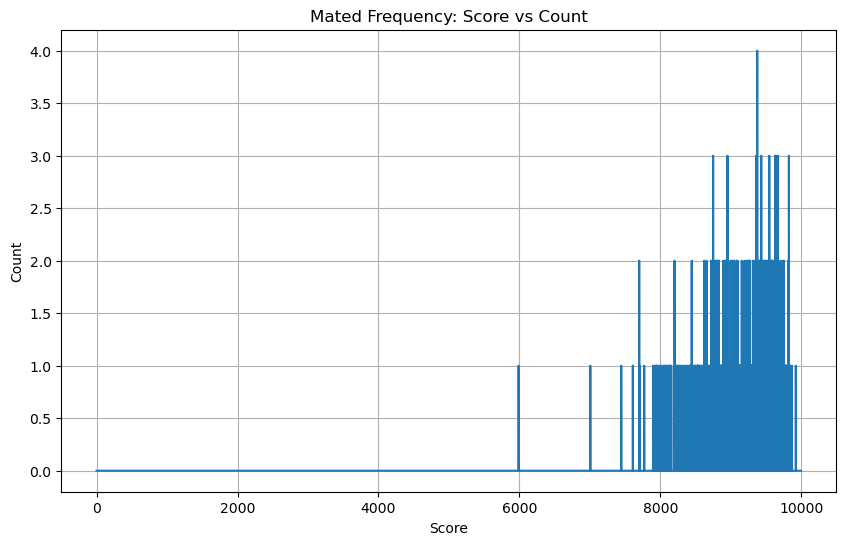

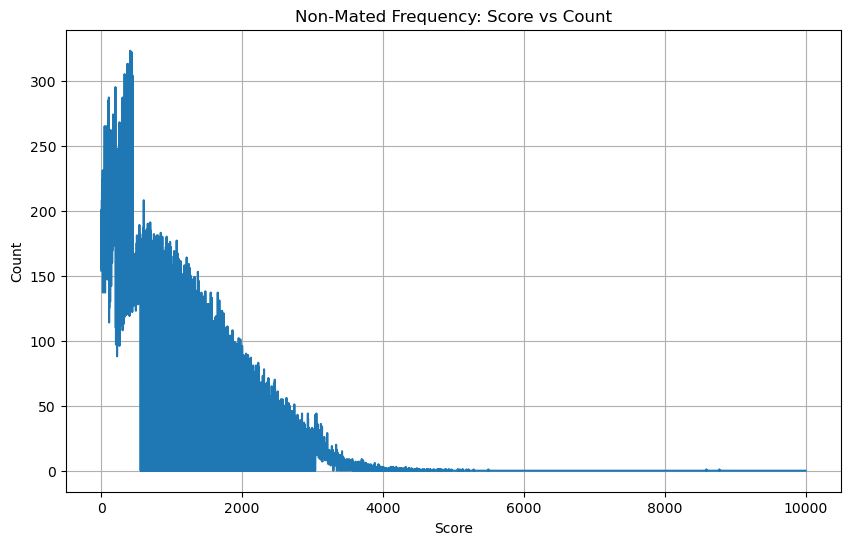

In [36]:
%reset
import gc # This is required for the ram fix
import pandas as pd # This is for the dataframe
import os # This is for the operating system functionalities like reading the file directory, etc.
import psutil
import numpy as np
import time # This is just a rough gauge for us to estimate how much time we require to process each file
from tkinter import Tk # This is to provide a user interface for the user to select the file/folder for the quality and matching scores
from tkinter.filedialog import askdirectory
from tkinter import filedialog as fd
import matplotlib.pyplot as plt # This is for the plotting of the graph
from sqlalchemy import create_engine # This is for us to interface with the SQL for the issuing of commands and retrieving information once that is done

def database_connection():
    DB_USER = 'root'
    try:
        with open(r'C:\Users\B&P\Documents\analytics_platform\DB_Password.txt', 'r') as file:
            DB_PASSWORD = file.read().strip()  # Strip any extra spaces/newlines
    except FileNotFoundError:
        raise Exception("DB_Password.txt file not found. Please make sure the password file is in the correct location.")
    DB_HOST = '127.0.0.1'
    DB_PORT = '3306'
    DB_NAME = 'inspectorate_implementation'
    global engine
    connection_string = f'mariadb://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
    engine = create_engine(connection_string)
database_connection()

# From here we need to quert the data and load it into a dataframe for analysis, this is the portion where we can potential read in chunks to save memory usage

query = "SELECT score, count FROM mated_frequency"
df_mated = pd.read_sql(query, con=engine)

plt.figure(figsize=(10,6))
plt.plot(df_mated['score'],df_mated['count'], marker='', linestyle='-')
plt.title('Mated Frequency: Score vs Count')
plt.xlabel('Score')
plt.ylabel('Count')
plt.grid(True)
plt.show()

query = "SELECT score, count FROM nonmated_frequency"
df_nonmated = pd.read_sql(query, con=engine)

plt.figure(figsize=(10,6))
plt.plot(df_nonmated['score'],df_nonmated['count'], marker='', linestyle='-')
plt.title('Non-Mated Frequency: Score vs Count')
plt.xlabel('Score')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [46]:
import pandas as pd

# Normalize the 'Frequency' column to range [0, 1]
df_mated['counts_normalized'] = (df_mated['count'] - df_mated['count'].min()) / (df_mated['count'].max() - df_mated['count'].min())

df_nonmated['counts_normalized'] = (df_nonmated['count'] - df_nonmated['count'].min()) / (df_nonmated['count'].max() - df_nonmated['count'].min())


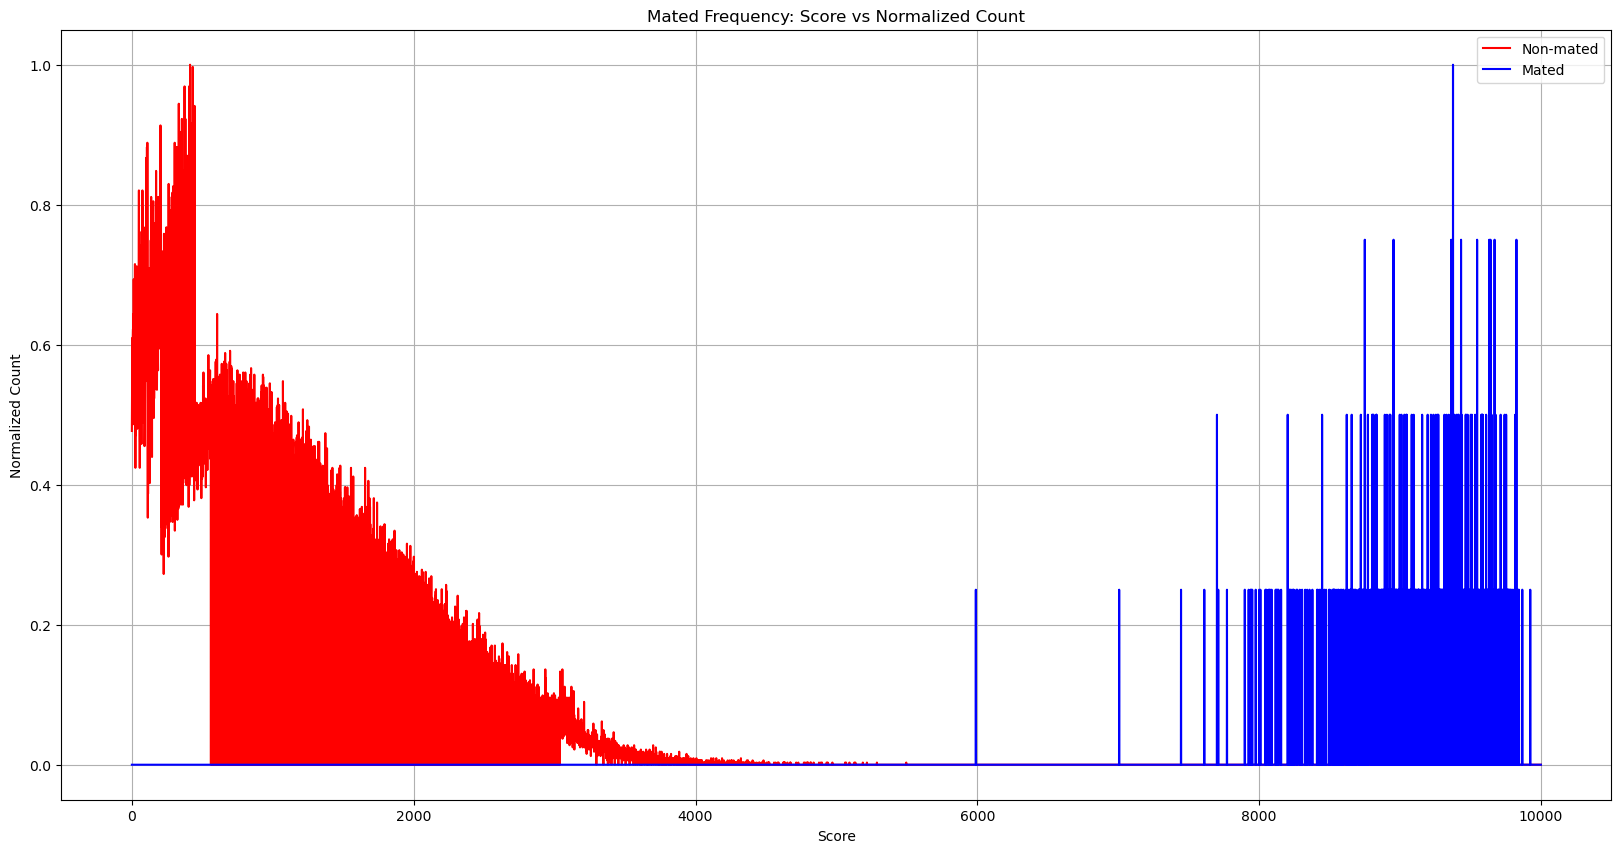

In [47]:
plt.figure(figsize=(20,10))
plt.plot(df_nonmated['score'],df_nonmated['counts_normalized'], linestyle='-', color = 'r', label = 'Non-mated')
plt.plot(df_mated['score'],df_mated['counts_normalized'], linestyle='-', color = 'b', label = 'Mated')
plt.title('Mated Frequency: Score vs Normalized Count')
plt.xlabel('Score')
plt.ylabel('Normalized Count')
plt.grid(True)
plt.legend()
plt.show()

EER: 0.0000, Threshold: 5496


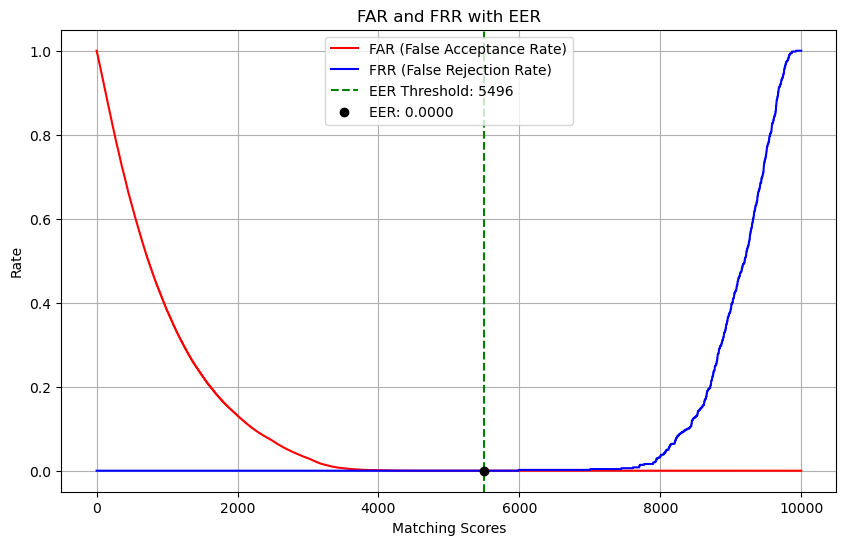

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Normalize counts to get probabilities
df_mated['probability'] = df_mated['count'] / df_mated['count'].sum()
df_nonmated['probability'] = df_nonmated['count'] / df_nonmated['count'].sum()

# Define thresholds (unique scores across both datasets)
thresholds = np.sort(np.unique(np.concatenate([df_mated['score'], df_nonmated['score']])))
FAR = []
FRR = []

# Compute FAR and FRR for each threshold
for threshold in thresholds:
    far = df_nonmated[df_nonmated['score'] >= threshold]['probability'].sum()
    frr = df_mated[df_mated['score'] < threshold]['probability'].sum()
    FAR.append(far)
    FRR.append(frr)

# Convert to numpy arrays
FAR = np.array(FAR)
FRR = np.array(FRR)

# Find EER
eer_index = np.argmin(np.abs(FAR - FRR))
eer_threshold = thresholds[eer_index]
eer = FAR[eer_index]

print(f"EER: {eer:.4f}, Threshold: {eer_threshold}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, FAR, label="FAR (False Acceptance Rate)", color="red")
plt.plot(thresholds, FRR, label="FRR (False Rejection Rate)", color="blue")
plt.axvline(eer_threshold, color="green", linestyle="--", label=f"EER Threshold: {eer_threshold}")
plt.scatter([eer_threshold], [eer], color="black", zorder=5, label=f"EER: {eer:.4f}")

plt.title("FAR and FRR with EER")
plt.xlabel("Matching Scores")
plt.ylabel("Rate")
plt.legend()
plt.grid()
plt.show()


# ROC Curve

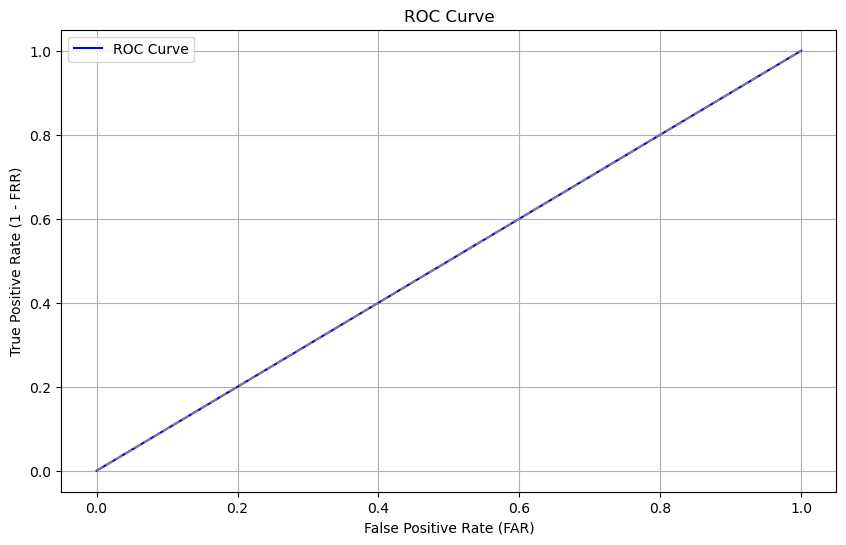

In [7]:
# Plotting the ROC Curve

# Establishing Connection to the database

from sklearn.metrics import roc_curve
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def database_connection():
    DB_USER = 'root'
    try:
        with open(r'C:\Users\B&P\Documents\analytics_platform\DB_Password.txt', 'r') as file:
            DB_PASSWORD = file.read().strip()  # Strip any extra spaces/newlines
    except FileNotFoundError:
        raise Exception("DB_Password.txt file not found. Please make sure the password file is in the correct location.")
    DB_HOST = '127.0.0.1'
    DB_PORT = '3306'
    DB_NAME = 'iNspectorate_implementation'
    global engine
    connection_string = f'mariadb://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
    engine = create_engine(connection_string)
database_connection()

query = "SELECT score, count FROM mated_frequency"
df_mated = pd.read_sql(query, con=engine)

query1 = "SELECT score, count FROM nonmated_frequency"
df_nonmated = pd.read_sql(query1, con=engine)

# Get genuine and impostor scores
y_true = np.concatenate([np.ones(len(df_mated)), np.zeros(len(df_nonmated))])  # 1 for genuine, 0 for impostor
y_scores = np.concatenate([df_mated['score'], df_nonmated['score']])  # Matching scores

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="ROC Curve", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal reference line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate (FAR)")
plt.ylabel("True Positive Rate (1 - FRR)")
plt.legend()
plt.grid()
plt.show()

# 3D plot of the quality score of live and enrolled with their corresponding matching score in the z axis

In [1]:
import gc # This is required for the ram fix
import pandas as pd # This is for the dataframe
import os # This is for the operating system functionalities like reading the file directory, etc.
import psutil
import numpy as np
import time # This is just a rough gauge for us to estimate how much time we require to process each file
from tkinter import Tk # This is to provide a user interface for the user to select the file/folder for the quality and matching scores
from tkinter.filedialog import askdirectory
from tkinter import filedialog as fd
import matplotlib.pyplot as plt # This is for the plotting of the graph
from sqlalchemy import create_engine # This is for us to interface with the SQL for the issuing of commands and retrieving information once that is done

def database_connection():
    DB_USER = 'root'
    try:
        with open(r'C:\Users\B&P\Documents\analytics_platform\DB_Password.txt', 'r') as file:
            DB_PASSWORD = file.read().strip()  # Strip any extra spaces/newlines
    except FileNotFoundError:
        raise Exception("DB_Password.txt file not found. Please make sure the password file is in the correct location.")
    DB_HOST = '127.0.0.1'
    DB_PORT = '3306'
    DB_NAME = 'iNspectorate_implementation'
    global engine
    connection_string = f'mariadb://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
    engine = create_engine(connection_string)
database_connection()
print("Connection to the DB has been established!")

Connection to the DB has been established!


In [2]:
# For the first query, we will be obtaining the information from compiled matching scores, we will need to map 
query = "SELECT ID1, ID2, `Matching Score` FROM compiled_matching_scores"

df_compiled = pd.read_sql(query, con=engine) # This is for you to insert the data from the SQL into a dataframe in pandas

# This set of codes is to check for mated and non mated pairs

df_compiled['Same_IDs'] = df_compiled['ID1'] == df_compiled['ID2']
df_compiled['Same_IDs'] = df_compiled['Same_IDs'].map({True: 'Y', False: 'N'})
#making 2 dataframes, basically here we are just copying the data that is mated and non-mated into the dataframe
df_true = df_compiled[df_compiled['Same_IDs'] == 'Y'].copy()
df_false = df_compiled[df_compiled['Same_IDs'] == 'N'].copy()
df_true.drop(df_true.tail(1).index,inplace=True)
# This is just to visualise that what we are doing is correct
# print(df_true)
# print(df_false)

# From here we need to drop the column called Same_IDs to remove the mated and non-mated labelling
df_true.drop(columns=['Same_IDs'], inplace=True)
df_false.drop(columns=['Same_IDs'], inplace=True)

print("Dropping the Same_IDs column")
print(df_true)
print(df_false)

Dropping the Same_IDs column
            ID1      ID2 Matching Score
358     0000315  0000315           8828
903     0000040  0000040           9825
1499    0000162  0000162           8832
1966    0000039  0000039           9713
2092    0000097  0000097           9414
...         ...      ...            ...
497977  0000365  0000365           8967
498335  0000094  0000094           9196
498764  0000044  0000044           9410
499500  0000122  0000122           9030
499546  0000216  0000216           9618

[1001 rows x 3 columns]
            ID1      ID2 Matching Score
0       0000370  0000315           2546
1       0000006  0000315           3576
2       0000376  0000315           0092
3       0000166  0000315           0066
4       0000294  0000315           0136
...         ...      ...            ...
499996  0000065  0000216           1997
499997  0000496  0000216           1661
499998  0000306  0000216           1606
499999  0000075  0000216           1235
500000  0000186  0000216  

In [3]:
# From here we need to load in the data for the compiled quality score

query = "SELECT ID, `Quality Score E`, `Quality Score L` FROM compiled_quality_scores"
df_EL = [] # We are just going to reuse this portion of the script
df_EL = pd.read_sql(query, con=engine)
print("DF for Enrolled and Live")
print(df_EL)

# Merge df_true with df_EL to get Quality Score E for ID1 and Quality Score L for ID2

df_mated = df_true.merge(df_EL[['ID', 'Quality Score L']], left_on='ID1', right_on='ID', how='left') \
                  .merge(df_EL[['ID', 'Quality Score E']], left_on='ID2', right_on='ID', how='left') \
                  .drop(columns=['ID_x', 'ID_y'])
'''
# Before we use df_true, we need to drop the duplicated column
df_true.drop(columns=["ID2"], axis=1, inplace=True)
print("DF for mated, dropped ID2")
print(df_true)

df_mated = df_EL.merge(df_true[['ID1', 'Matching Score']], left_on='ID', right_on='ID1', how='left')
#df_mated = df_true.merge(df_EL[['ID', 'Quality Score L']], left_on='ID1', right_on='ID', how='left')

#df_mated = df_true.merge(df_EL[['ID', 'Quality Score E']], left_on='ID2', right_on='ID', how='left') 
'''
# Rename columns for clarity
df_mated.rename(columns={
    'Quality Score L': 'Quality Score L (ID1)',
    'Quality Score E': 'Quality Score E (ID2)'
}, inplace=True)
df_mated = df_mated[['Quality Score L (ID1)', 'Quality Score E (ID2)', 'Matching Score']]
'''


# In the event for duplicates and you want to check
duplicates = df_mated[df_mated.duplicated(subset='ID', keep=False)]
print(duplicates)
'''
# Drop original ID1 and ID2 columns, keeping only quality scores and matching score
# df_mated = df_mated[['Quality Score L (ID1)', 'Quality Score E (ID2)', 'Matching Score']]
print(df_mated)


DF for Enrolled and Live
          ID  Quality Score E  Quality Score L
0    0000000         0.930645         0.940431
1    0000001         0.949822         0.951558
2    0000002         0.951468         0.948659
3    0000003         0.977260         0.943891
4    0000004         0.955057         0.901112
..       ...              ...              ...
495  0000495         0.972560         0.951545
496  0000496         0.977797         0.952418
497  0000497         0.974838         0.956104
498  0000498         0.920716         0.902645
499  0000499         0.958912         0.952807

[500 rows x 3 columns]
      Quality Score L (ID1)  Quality Score E (ID2) Matching Score
0                  0.807377               0.891563           8828
1                  0.936247               0.949583           9825
2                  0.952117               0.942011           8832
3                  0.929928               0.953407           9713
4                  0.938143               0.949273       

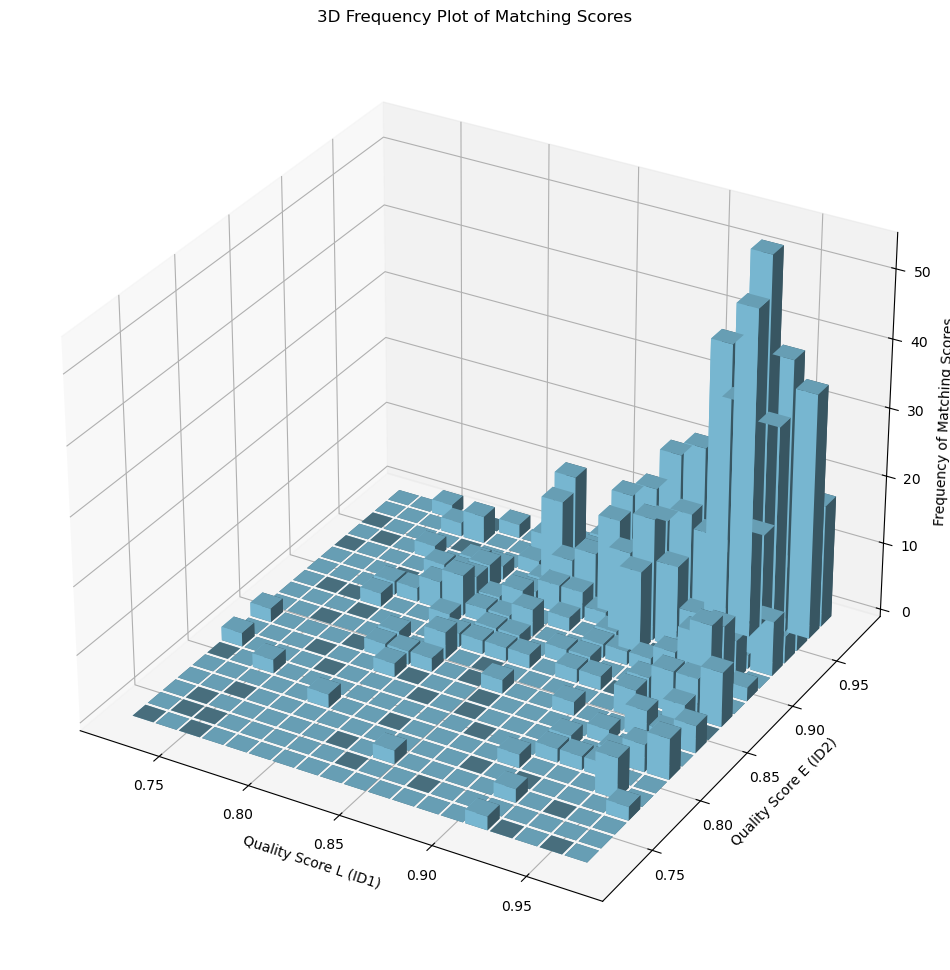

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create bins for Quality Score E, Quality Score L, and Matching Score
bins_E = np.linspace(df_mated['Quality Score L (ID1)'].min(), df_mated['Quality Score L (ID1)'].max(), 20)
bins_L = np.linspace(df_mated['Quality Score E (ID2)'].min(), df_mated['Quality Score E (ID2)'].max(), 20)

# 2D histogram to count frequency
hist, xedges, yedges = np.histogram2d(
    df_mated['Quality Score L (ID1)'], 
    df_mated['Quality Score E (ID2)'], 
    bins=[bins_E, bins_L]
)

# Prepare the grid for plotting
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)  # Base of bars at 0

# Flatten the histogram for bar heights
dz = hist.ravel()

# Bar dimensions
dx = dy = (xedges[1] - xedges[0]) * 0.9  # Adjust bar width/length

# Create 3D bar plot
fig = plt.figure(figsize=(12, 15))
ax = fig.add_subplot(111, projection='3d')

# Plotting the bars
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True, color='skyblue')

# Axis labels
ax.set_xlabel('Quality Score L (ID1)')
ax.set_ylabel('Quality Score E (ID2)')
ax.set_zlabel('Frequency of Matching Scores')

# Title
ax.set_title('3D Frequency Plot of Matching Scores')

# Show plot
plt.show()


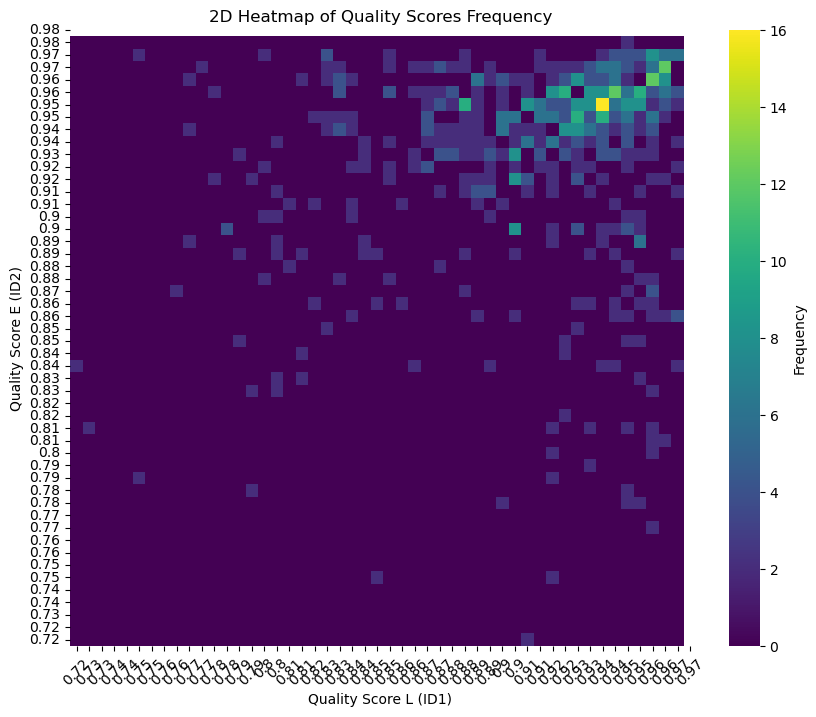

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create bins for Quality Score E and Quality Score L
bins_E = np.linspace(df_mated['Quality Score L (ID1)'].min(), df_mated['Quality Score L (ID1)'].max(), 50)
bins_L = np.linspace(df_mated['Quality Score E (ID2)'].min(), df_mated['Quality Score E (ID2)'].max(), 50)

# Create a 2D histogram (frequency counts)
heatmap_data, xedges, yedges = np.histogram2d(
    df_mated['Quality Score L (ID1)'],
    df_mated['Quality Score E (ID2)'],
    bins=[bins_E, bins_L]
)

# Plotting the heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data.T,  # Transpose to align correctly
    cmap='viridis',  # Color map (can be changed to 'coolwarm', 'plasma', etc.)
    xticklabels=np.round(xedges, 2),  # Show Quality Score E labels
    yticklabels=np.round(yedges, 2),  # Show Quality Score L labels
    cbar_kws={'label': 'Frequency'}   # Color bar label
)

# Axis labels and title
plt.xlabel('Quality Score L (ID1)')
plt.ylabel('Quality Score E (ID2)')
plt.title('2D Heatmap of Quality Scores Frequency')

# Adjust tick visibility for clarity
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.gca().invert_yaxis()
# Show the plot
plt.show()


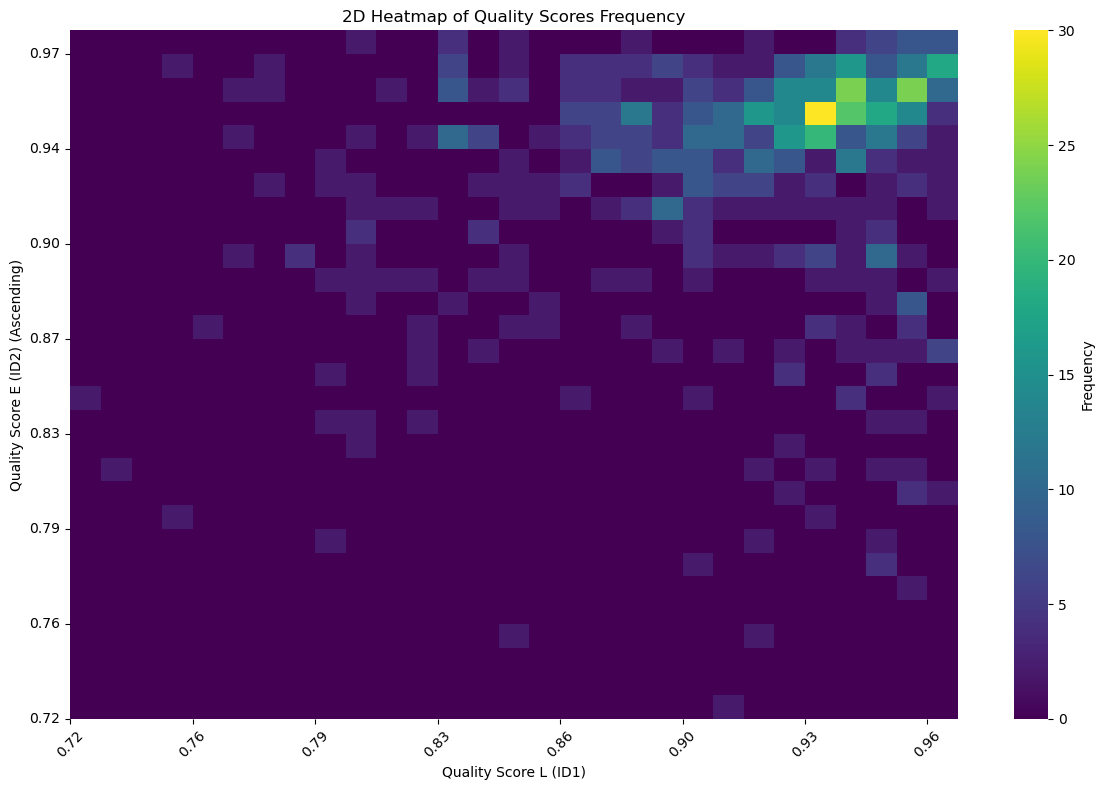

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create bins for Quality Score E (ID1) and Quality Score E (ID2)
bins_E = np.linspace(df_mated['Quality Score L (ID1)'].min(), df_mated['Quality Score L (ID1)'].max(), 30)
bins_L = np.linspace(df_mated['Quality Score E (ID2)'].min(), df_mated['Quality Score E (ID2)'].max(), 30)

# Create a 2D histogram
heatmap_data, xedges, yedges = np.histogram2d(
    df_mated['Quality Score L (ID1)'],
    df_mated['Quality Score E (ID2)'],
    bins=[bins_E, bins_L]
)

# Plotting the heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    heatmap_data.T,               # Transpose for correct orientation
    cmap='viridis',               # Color map
    cbar_kws={'label': 'Frequency'}  # Color bar label
)

# Invert the Y-axis to make it ascending
plt.gca().invert_yaxis()

# Adjust X-axis ticks
x_tick_positions = np.linspace(0, len(xedges)-2, 8, dtype=int)   # Adjust tick frequency
x_tick_labels = [f'{xedges[i]:.2f}' for i in x_tick_positions]    # Format labels
plt.xticks(ticks=x_tick_positions, labels=x_tick_labels, rotation=45)

# Adjust Y-axis ticks
y_tick_positions = np.linspace(0, len(yedges)-2, 8, dtype=int)    # Fewer ticks for clarity
y_tick_labels = [f'{yedges[i]:.2f}' for i in y_tick_positions]    # Format labels
plt.yticks(ticks=y_tick_positions, labels=y_tick_labels, rotation=0)

# Axis labels and title
plt.xlabel('Quality Score L (ID1)')
plt.ylabel('Quality Score E (ID2) (Ascending)')
plt.title('2D Heatmap of Quality Scores Frequency')

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()